## 1) Importing Necesseties

In [1]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import zipfile
import os
import cv2

## 2) Generate the Data Matrix and the Label vector
* Convert every image into a vector of 10,304 values corresponding to the image size.
* Stack the 400 vector into a single Data Matrix D and generate the label vector y.
* The labels are integers from 1:40 corresponding to the subject ids.
# ____________

**constructDataMatrix** function is used to generate the data matrix from the provided images. <br>
It loops over the images and flattens it to its corresponding values.<br>
It also construct the label vector by appending id for each person.

In [2]:

def constructDataMatrix(folder):
    D = np.zeros((400, 10304))
    Y = []
    ids = 1
    ind = 0

    for folderName in range(40):
    
        name = "s"+ str(folderName + 1)
        path = os.path.join(folder, name)
        for imgName in range(10):
            name_of_image = str(imgName+1)+".pgm" 
            img = cv2.imread(os.path.join(path, name_of_image), 0)
            if img is not None:
                Y.append(ids)
                D[ind] = img.flatten()
                ind += 1
        ids += 1
 
    return D,Y

In [3]:
D,Y =constructDataMatrix('orl')


In [4]:
D

array([[ 48.,  49.,  45., ...,  47.,  46.,  46.],
       [ 60.,  60.,  62., ...,  32.,  34.,  34.],
       [ 39.,  44.,  53., ...,  29.,  26.,  29.],
       ...,
       [125., 119., 124., ...,  36.,  39.,  40.],
       [119., 120., 120., ...,  89.,  94.,  85.],
       [125., 124., 124., ...,  36.,  35.,  34.]])

## 3) Split the Dataset into Training and Test sets
* From the Data Matrix D400x10304 keep the odd rows for training and the even rows for testing. 
* This will give you 5 instances per person for training and 5 instances per person for testing.
* Split the labels vector accordingly.
# ____________

**Split** function is used to split the data matrix and label vector between the training and test sets as it is required.

In [5]:
def Split(data_matrix):
    training = data_matrix[::2]  # odd rows for training.
    testing = data_matrix[1::2]  # even rows for testing.
    return training, testing

In [6]:
training_set, testing_set = Split(D)
training_label, testing_label = Split(Y)

## 4) Dimensionality Reduction using PCA and Classification using 1-NN

* Use the pseudo code of PCA given in lecture to find the projection matrix U.
# ____________


## Helping functions

### (1) **sort_eigen()** function
Is used to:<br>
1- Construct a dictionary that maps each eigen value to its corresponding eigen vector. <br>
2- Sort the keys (eigen values) in a reverse order and return it.

In [7]:
def sort_eigen(eigen_values, eigen_vectors):
    eigen_dict = {}
    for i in range(len(eigen_values)):
        eigen_dict[eigen_values[i]] = eigen_vectors[:,i]
    return sorted(eigen_dict.keys(), reverse = True), eigen_dict
    

### (2) **fractions()** function
This function is used to calculate the **r** which is the smalles number of eigen vectors that their eigen values match the constraint of choosing the dimensionality. (**f(r) >= alpha**).<br>
It uses the mentioned dictionary and iterate over it using the values in the sorted eigen values returned from the above function.

In [8]:
def fractions(sorted_Eigen, eigen_dict, total_variance_sum, alpha):
    sum_ = 0;
    r = 0
    for key in sorted_Eigen:
        sum_ += key
        frac = sum_/total_variance_sum
        r += 1
        if frac >= alpha:
            break
    return r 

### (3) get_projection_matrix() function
This function is used to get the specific eigen vectors which have the largest r eigen values and stack them together to construct the **projection matrix**.

In [9]:
def get_projection_matrix(r, sorted_Eigen, eigen_dict):
    U=np.zeros((r, 10304))
    
    for i in range (r):
        U[i] = eigen_dict[sorted_Eigen[i]]
    
    return U 

### (4) preper_PCA() function
It implements the first 5 steps in the PCA algorithm:
 * calculate mean
 * centrize the data
 * compute covariance matrix
 * compute eigen values and eigen vectors <br>
It also prepare the sorted dictionary to be used in calculating r and the projection matrix.

In [10]:
def preper_PCA(matrix):
    mean_matrix = np.mean(matrix, axis = 0)
    print("mean_matrix", mean_matrix)
    Z_matrix = matrix - np.transpose(mean_matrix)
    print("Z_matrix", Z_matrix)
    CovarianceMatrix =(1/len(matrix)) * np.dot(np.transpose(Z_matrix), Z_matrix)
    print("CovarianceMatrix",CovarianceMatrix)
    
    EigenValues, Eigenvectors = np.linalg.eig(CovarianceMatrix)
    EigenValues = EigenValues.real
    Eigenvectors = Eigenvectors.real
    print("EigenValues",EigenValues)
    print("Eigenvectors", Eigenvectors)
    
    sorted_Eigen, eigen_dict = sort_eigen(EigenValues, Eigenvectors)
    #print("sorted_Eigen", sorted_Eigen)
    
    TotalVariance = CovarianceMatrix.diagonal()
    #print("Total Variance List :", TotalVariance) #list of diagonal element from COV Matrix
    TotalVarianceSum = TotalVariance.sum() 
    #print("Sum Of The Total Variance :", TotalVarianceSum) # Sum of this list
    
    return sorted_Eigen, eigen_dict, TotalVarianceSum
    

In [24]:
sorted_Eigen, eigen_dict, TotalVarianceSum = preper_PCA(training_set)

mean_matrix [86.115 86.265 86.685 ... 76.5   77.395 77.085]
Z_matrix [[-38.115 -37.265 -41.685 ... -29.5   -31.395 -31.085]
 [-47.115 -42.265 -33.685 ... -47.5   -51.395 -48.085]
 [-22.115 -10.265  -6.685 ... -41.5   -40.395 -38.085]
 ...
 [ 41.885  38.735  38.315 ...   8.5    12.605   6.915]
 [ 42.885  40.735  46.315 ...  16.5    15.605  15.915]
 [ 32.885  33.735  33.315 ...  12.5    16.605   7.915]]
CovarianceMatrix [[1241.511775 1237.489525 1220.456225 ...  -69.8075    -99.755425
   -43.884775]
 [1237.489525 1250.244775 1227.058475 ...  -81.5325   -110.499675
   -55.222525]
 [1220.456225 1227.058475 1222.145775 ...  -79.0825   -114.060575
   -67.653225]
 ...
 [ -69.8075    -81.5325    -79.0825   ... 1894.       1865.0575
  1682.5425  ]
 [ -99.755425 -110.499675 -114.060575 ... 1865.0575   1970.238975
  1809.101425]
 [ -43.884775  -55.222525  -67.653225 ... 1682.5425   1809.101425
  1888.737775]]
EigenValues [ 2.89336806e+06  2.01725036e+06  1.14824189e+06 ... -4.86572846e-14
  7.152

### (5) PCA()
This function is used to calculate **r** and the projection matrix depending on the value of **alpha** passed to it.

In [25]:
def PCA (matrix, alpha):
    
    r = fractions(sorted_Eigen, eigen_dict, TotalVarianceSum, alpha)
    U = get_projection_matrix(r, sorted_Eigen, eigen_dict)
    
    return U

### 4.1) Using the 1_NN classifier

* try the following values of alpha, {0.8,0.85,0.9,0.95}.
* Project the training set and test sets separately using the same projection matrix.
* Use a simple classifier (first Nearest Neighbor to determine the class labels).
# ____________

## Helping functions

### (1) KNN_Classifier()
This function takes K, training and test sets as a parameters to apply on them the classification by fitting the training set first, then predict the labels of the test set. (fit and predict are built-in functions)<br>
It returns the predicted label.

In [26]:
def KNN_Classifier(num_neighbors, reduced_training, reduced_testing):
    knn = KNeighborsClassifier(n_neighbors=num_neighbors)
    knn.fit(reduced_training, training_label)
    predict_label = knn.predict(reduced_testing)
    return predict_label


### (2) accuracy()
This function calculates the accuracy of the predicted label by counting the number of the correct predictions and dividing it by the total number of the original labels.

In [27]:
def accuracy(predict_label):
    match_num=np.sum(testing_label == predict_label)
    fraction_of_accuracy = match_num / len(testing_label)
    return fraction_of_accuracy

### (3) try_alpha()
This function tries all the alpha values given in the pdf to calculate their corresponding reduced training and test sets. <br>
Then it stacks the 4 reduced training sets together in one list, and do the same for the 4 reduced test sets in another list to be used later.

In [28]:
alphas = [0.8, 0.85, 0.9, 0.95]
reduced_training_list = []
reduced_testing_list = []
def try_alpha():
    accuracy_list = []
    predict_label_list = [] 
    for alpha in alphas:
        ProjectionMatrix_train = PCA (training_set, alpha)
        #ProjectionMatrix_test = PCA (testing_set, alpha)
        reduced_training = np.dot(training_set, np.transpose(ProjectionMatrix_train))
        reduced_testing = np.dot(testing_set, np.transpose(ProjectionMatrix_train))
        
        reduced_training_list.append(reduced_training)
        reduced_testing_list.append(reduced_testing)
     

### (4)  KNN_prediction()
This function is just used to call the mentioned KNN_Classifier and accuracy functions with a specific K to get the predicted label and calculate the accuracy of it. 

In [29]:
def KNN_prediction(num_neighbors, reduced_training, reduced_testing):
    predict_label = KNN_Classifier(num_neighbors, reduced_training, reduced_testing)
    accuracy_percentage = accuracy(predict_label) * 100
    return accuracy_percentage #, predict_label_list

In [30]:
try_alpha()  #by this we store list of the value of reduced_training, reduced_testing for all alphas.

### 4.2) Compare Accuracy

* Report Accuracy for every value of alpha separately.
* Can you find a relation between alpha and the classification accuracy

## Helping Functions

### (1) report_accuracy()
This function is used to plot the relation between the different values of alpha and the accuracy for a fixed K.

In [31]:
def report_accuracy(accuracy_list, num_neighbors):
    fig = plt.scatter(alphas, accuracy_list, color = (0.5,0.1,0.5,0.6)) #plt.scatter(alphas, accuracy_list)
    plt.title('Accuray of different alphas, where K is '+ str(num_neighbors))
    plt.xlabel('Alpha values')
    plt.ylabel('Accuray values')
    plt.show()

### (2) loop_on_reduced()
This function is used to iterate over the reduced training and test lists to calculate the accuracy of each alpha, and then stack them on one accuracy list to be returned.

In [32]:
# for 1-NN classifier 
def loop_on_reduced(num_neighbors):
    accuracy_list =[]
    for i in range(4):
        accuracy_list.append(KNN_prediction(num_neighbors, reduced_training_list[i], reduced_testing_list[i]))
    print(accuracy_list)
    report_accuracy(accuracy_list, num_neighbors)
    return accuracy_list

[95.0, 95.0, 94.0, 94.0]


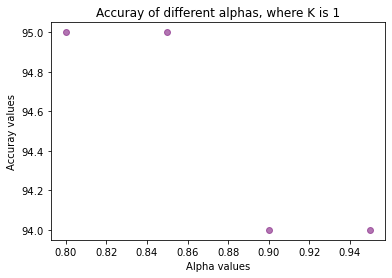

In [33]:
list_accuracies = []
list_accuracies.append(loop_on_reduced(1))
# print(list_accuracies)

## 5) Hyper-parameter Tuning

### 5.1) Set the number of neighbors in the K-NN classifier to 3,5,7. 

Applying the KNN_prediction function on different K values.

[89.5, 89.5, 89.0, 89.5]


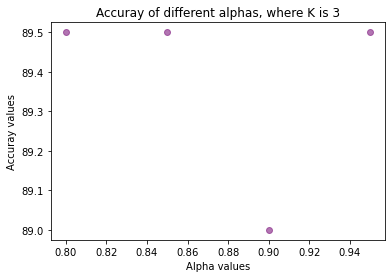

[85.0, 84.5, 83.5, 84.5]


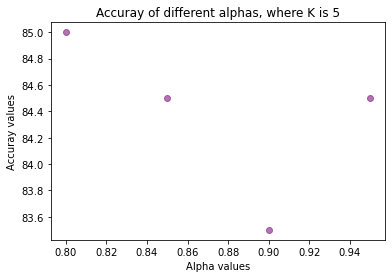

[80.5, 77.5, 77.0, 74.0]


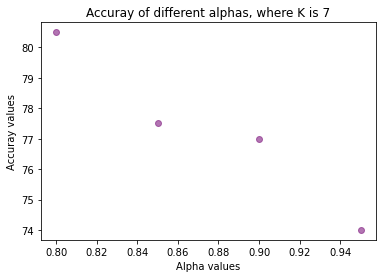

[[95.0, 95.0, 94.0, 94.0], [89.5, 89.5, 89.0, 89.5], [85.0, 84.5, 83.5, 84.5], [80.5, 77.5, 77.0, 74.0]]


In [34]:
k_list = [1,3,5,7]

for k in k_list[1:] :
    list_accuracies.append (loop_on_reduced(k))
print(list_accuracies)

### 5.2) Break ties at your preferred strategy.
Depending on what we understood, ties happens when the K is even, so to break ties with:
* First Nearest Neighbor (1NN)
* Randomly changing K until tie is broken

### 5.3) Plot (or tabulate) the performance measure (accuracy) against the K value.

* As shown in the below plots if the K increasing the total accuracy decreasing.

In [35]:

def report_accuracy_vs_K(alpha, new_column_accuracy):
    
    fig = plt.scatter(k_list,new_column_accuracy, color = (0.5,0.1,0.5,0.6)) #plt.scatter(alphas, accuracy_list)
    plt.title('The performance measure against the K value, where alpha is '+ str(alpha))
    plt.xlabel('K values')
    plt.ylabel('Accuray values')
    plt.show()

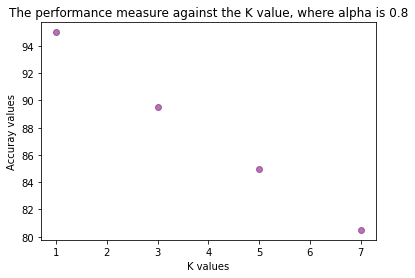

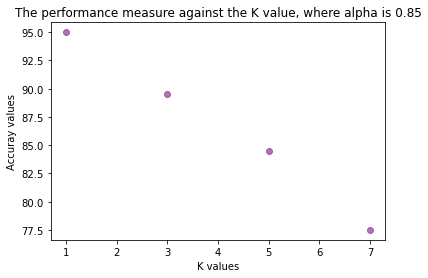

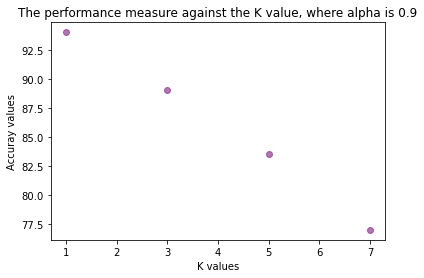

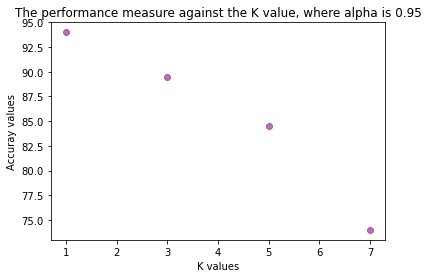

In [36]:
col_ind = 0
for a in alphas:
    new_column_accuracy = [item[col_ind] for item in list_accuracies]
    report_accuracy_vs_K(a,new_column_accuracy)
    col_ind+= 1